In [1]:
#standard
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack
sns.set_style("white")

#text processing
import re
import nltk
import string
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import CountVectorizer

#model selection and fitting
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Classic Horror Authors

In this notebook I want to create features from the text, including a vecotrized count of words, to predict the author who wrote the sentence.

+ Create feautres from text information such as the length, average word length, and number of unique words in each sentence
+ Create a sparse matrix of vectorized word counts
+ Train a naive Bayes classifier on the data 
    + Learn best paramters using a grid search
    
We begin by loading the data;

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [4]:
train.shape

(19579, 3)

In [5]:
y_train = train.author.values

## Visualize 

There are some fun visualizations we could take a look at (and I might come back to do so), but for now, let's just take a look at the number of sentences provided from each author to make sure we have a fairly balance data set.

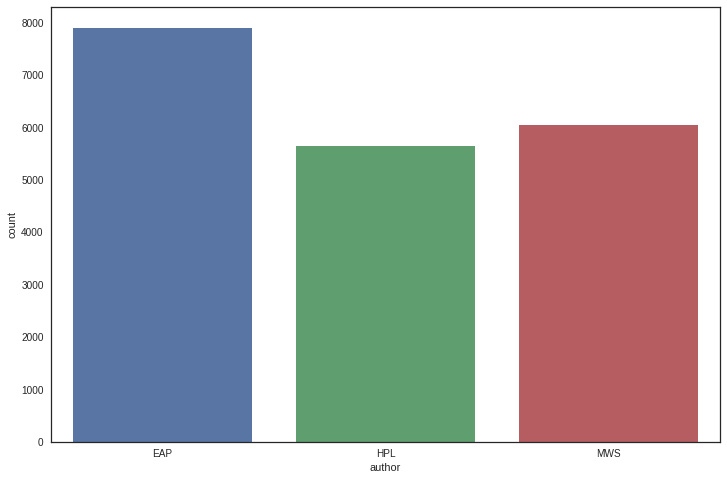

In [6]:
plt.figure(figsize=(12,8))
sns.countplot(train['author']);

## Features Engineering

Next we want to build are features from the text data and add them to our training and testing dataframes.

In [7]:
train["num_words"] = train["text"].apply(lambda txt: len(str(txt).split()))
test["num_words"] = test["text"].apply(lambda txt: len(str(txt).split()))

In [8]:
train["mean_word_len"] = train["text"].apply(lambda txt: np.mean([len(word) for word in str(txt).split()]))
test["mean_word_len"] = test["text"].apply(lambda txt: np.mean([len(word) for word in str(txt).split()]))

In [9]:
train["unique_words"] = train["text"].apply(lambda txt: len(set(str(txt).split())))
test["unique_words"] = test["text"].apply(lambda txt: len(set(str(txt).split())))

In [10]:
train.head()

,id,text,author,num_words,mean_word_len,unique_words
0,id26305,"This process, however, afforded me no means of...",EAP,41,4.658537,35
1,id17569,It never once occurred to me that the fumbling...,HPL,14,4.142857,14
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,36,4.583333,32
3,id27763,How lovely is spring As we looked from Windsor...,MWS,34,5.088235,32
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,27,5.481481,25


## Corpus

To create and train our vectorized count, we need to clean the text data and create a collection of sentences that contain non-stopwords without punctuation or capitalization.

In [11]:
stop_words = stopwords.words('english')

In [12]:
train_corpus = train.text.str.lower().str.replace('[^\w\s]','').str.split()
train_corpus = [[word for word in sentence if word not in stop_words] for sentence in train_corpus]

In [13]:
train_corpus = [' '.join(word) for word in train_corpus]

In [14]:
test_corpus = test.text.str.lower().str.replace('[^\w\s]','').str.split()
test_corpus = [[word for word in sentence if word not in stop_words] for sentence in test_corpus]

In [15]:
test_corpus = [' '.join(word) for word in test_corpus]

In [16]:
train = train.assign(corpus=train_corpus)
test = test.assign(corpus=test_corpus)

## Find Best Parameters

We will not use the `CountVectorizer` and the mulinomial naive bayes classifier in a pipeline to process and fit our data. We can then use a Gridsearch to iterate through some parameters and find the best ones. Note that due to keep thing moving quickly our parameters are based on the fit using only the vectorized word counts, the other text feautres are not included.

In [17]:
#transform our vector corpus to an numpy arr`ay
X_train = np.array(train_corpus)

#create a pipeline classified
clf = Pipeline([('vect', CountVectorizer()),
                      ('clf', MultinomialNB()),])

clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [18]:
#use grid search to find the best parameters

params = {'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
          'clf__alpha': (0.01, 0.05, 0.1, 0.3, 0.5, 0.8),}

clf_cv = GridSearchCV(clf, params)
clf_cv.fit(X_train, y_train)


#return best parameters to train our final model with
best_params = clf_cv.best_params_

## Create Spare Matrix of All Features and Fit Best Model

Now that we have found the best parameters, we will build a sparse matrix that includes our text features and the matrix of vectorized word counts. We can then fit the model and build our submission file.

In [19]:
best_params

{'clf__alpha': 0.5, 'vect__ngram_range': (1, 2)}

In [20]:
tfidf_vec = CountVectorizer(stop_words='english', ngram_range=(1, 2))
tfidf_vec.fit(train_corpus)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [21]:
features = ['num_words', 'mean_word_len', 'unique_words']

In [22]:
X_train = hstack((tfidf_vec.fit_transform(train_corpus),train[features].values),
                           format='csr')
X_train_col= tfidf_vec.get_feature_names()+train[features].columns.tolist()

In [23]:
X_test = hstack((tfidf_vec.transform(test_corpus),test[features].values),
                          format='csr')
X_test_col= tfidf_vec.get_feature_names()+test[features].columns.tolist()

In [24]:
clf = MultinomialNB(alpha=0.5)
clf.fit(X_train, y_train)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

In [25]:
y_pred = clf.predict(X_train)

In [26]:
accuracy_score(y_train, y_pred)

0.98896777159201188

We got a pretty greate accuracy score, and below we can see that a lot of the confusion was in classfiying Poe vs Lovecraft.

In [27]:
labels = ['EAP', 'HPL', 'MWS' ]
conf =confusion_matrix(y_train, y_pred, labels)

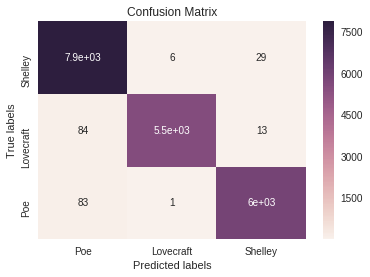

In [28]:
ax= plt.subplot()
sns.heatmap(conf, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Poe', 'Lovecraft', 'Shelley']); 
ax.yaxis.set_ticklabels(['Poe', 'Lovecraft', 'Shelley']);

In [29]:
X_test.shape

(8392, 212225)

In [30]:
y_pred_prob = clf.predict_proba(X_test)

In [31]:
submission_df = pd.DataFrame(y_pred_prob, columns = ['EAP', 'HPL', 'MWS'])

In [32]:
submission_df['id'] = test['id'].values
submission_df = submission_df[['id','EAP', 'HPL', 'MWS']]

In [33]:
submission_df.head()

,id,EAP,HPL,MWS
0,id02310,0.027979,4.152195e-05,9.719799e-01
1,id24541,1.000000,1.332372e-09,1.143491e-08
2,id00134,0.913701,8.629472e-02,4.039604e-06
3,id27757,0.998521,1.478893e-03,1.091168e-09
4,id04081,0.995457,3.064441e-03,1.478647e-03


In [34]:
#submission_df.to_csv('submission.csv', index=False) 

Completed the late submission, 0.55 score leaves a lot of room for improvement, but the competion is over and I mostly wanted to practice extracting text features and tuning a Naive Baye Classified, so I'd say mission accomplished. 

Thanks for making it this far!